## Test CNN

The objective of this notebook is test the usability of the processed data in a toy CNN

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math
import json
import sys
import seaborn as sns

In [2]:
# Make tf to ignore GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#restrict GPU mem
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU Memory limited!')
except:
    print('It was not possible to limit GPU memory')

[]
It was not possible to limit GPU memory


In [3]:
# Load dataset
local_tf_datasets="/home/hhughes/Documents/Master_Thesis/Project/datasets/tensorflow_datasets"
dataset, metadata = tfds.load(
    'MPP_dataset', 
    data_dir=local_tf_datasets, 
    # If False, returns a dictionary with all the features
    as_supervised=True, 
    shuffle_files=False,
    with_info=True)

# Load the splits
train_data, val_data, test_data = dataset['train'], dataset['validation'], dataset['test']

In [4]:
metadata

tfds.core.DatasetInfo(
    name='mpp_dataset',
    version=1.0.0,
    description='Dataset containing images of Multiplexed protein maps.
The elements of this data sets are multichannel images of singel cells alongside with its transcription rate.
This Dataset was builded after a preprocessing using the python script Transform_MPPData_into_images_from_script.ipynb. During this preprocessing the original MPPData was:
- Converted into images.
- Cleaned. Border and mitotic cells were removed.
- Normalized. Each channel was normalized using scale parameters obtained from the training set.
- Target value (scalar) calculated. The transcription rate was approximated taking the average of the measured pixels of the channel 00_EU. It is important to mention that the the target value was calculated BEFORE the normalization process.

input_channels:
['00_DAPI', '07_H2B', '01_CDK9_pT186', '03_CDK9', '05_GTF2B', '07_SETD1A', '08_H3K4me3', '09_SRRM2', '10_H3K27ac', '11_KPNA2_MAX', '12_RB1_pS807_S811

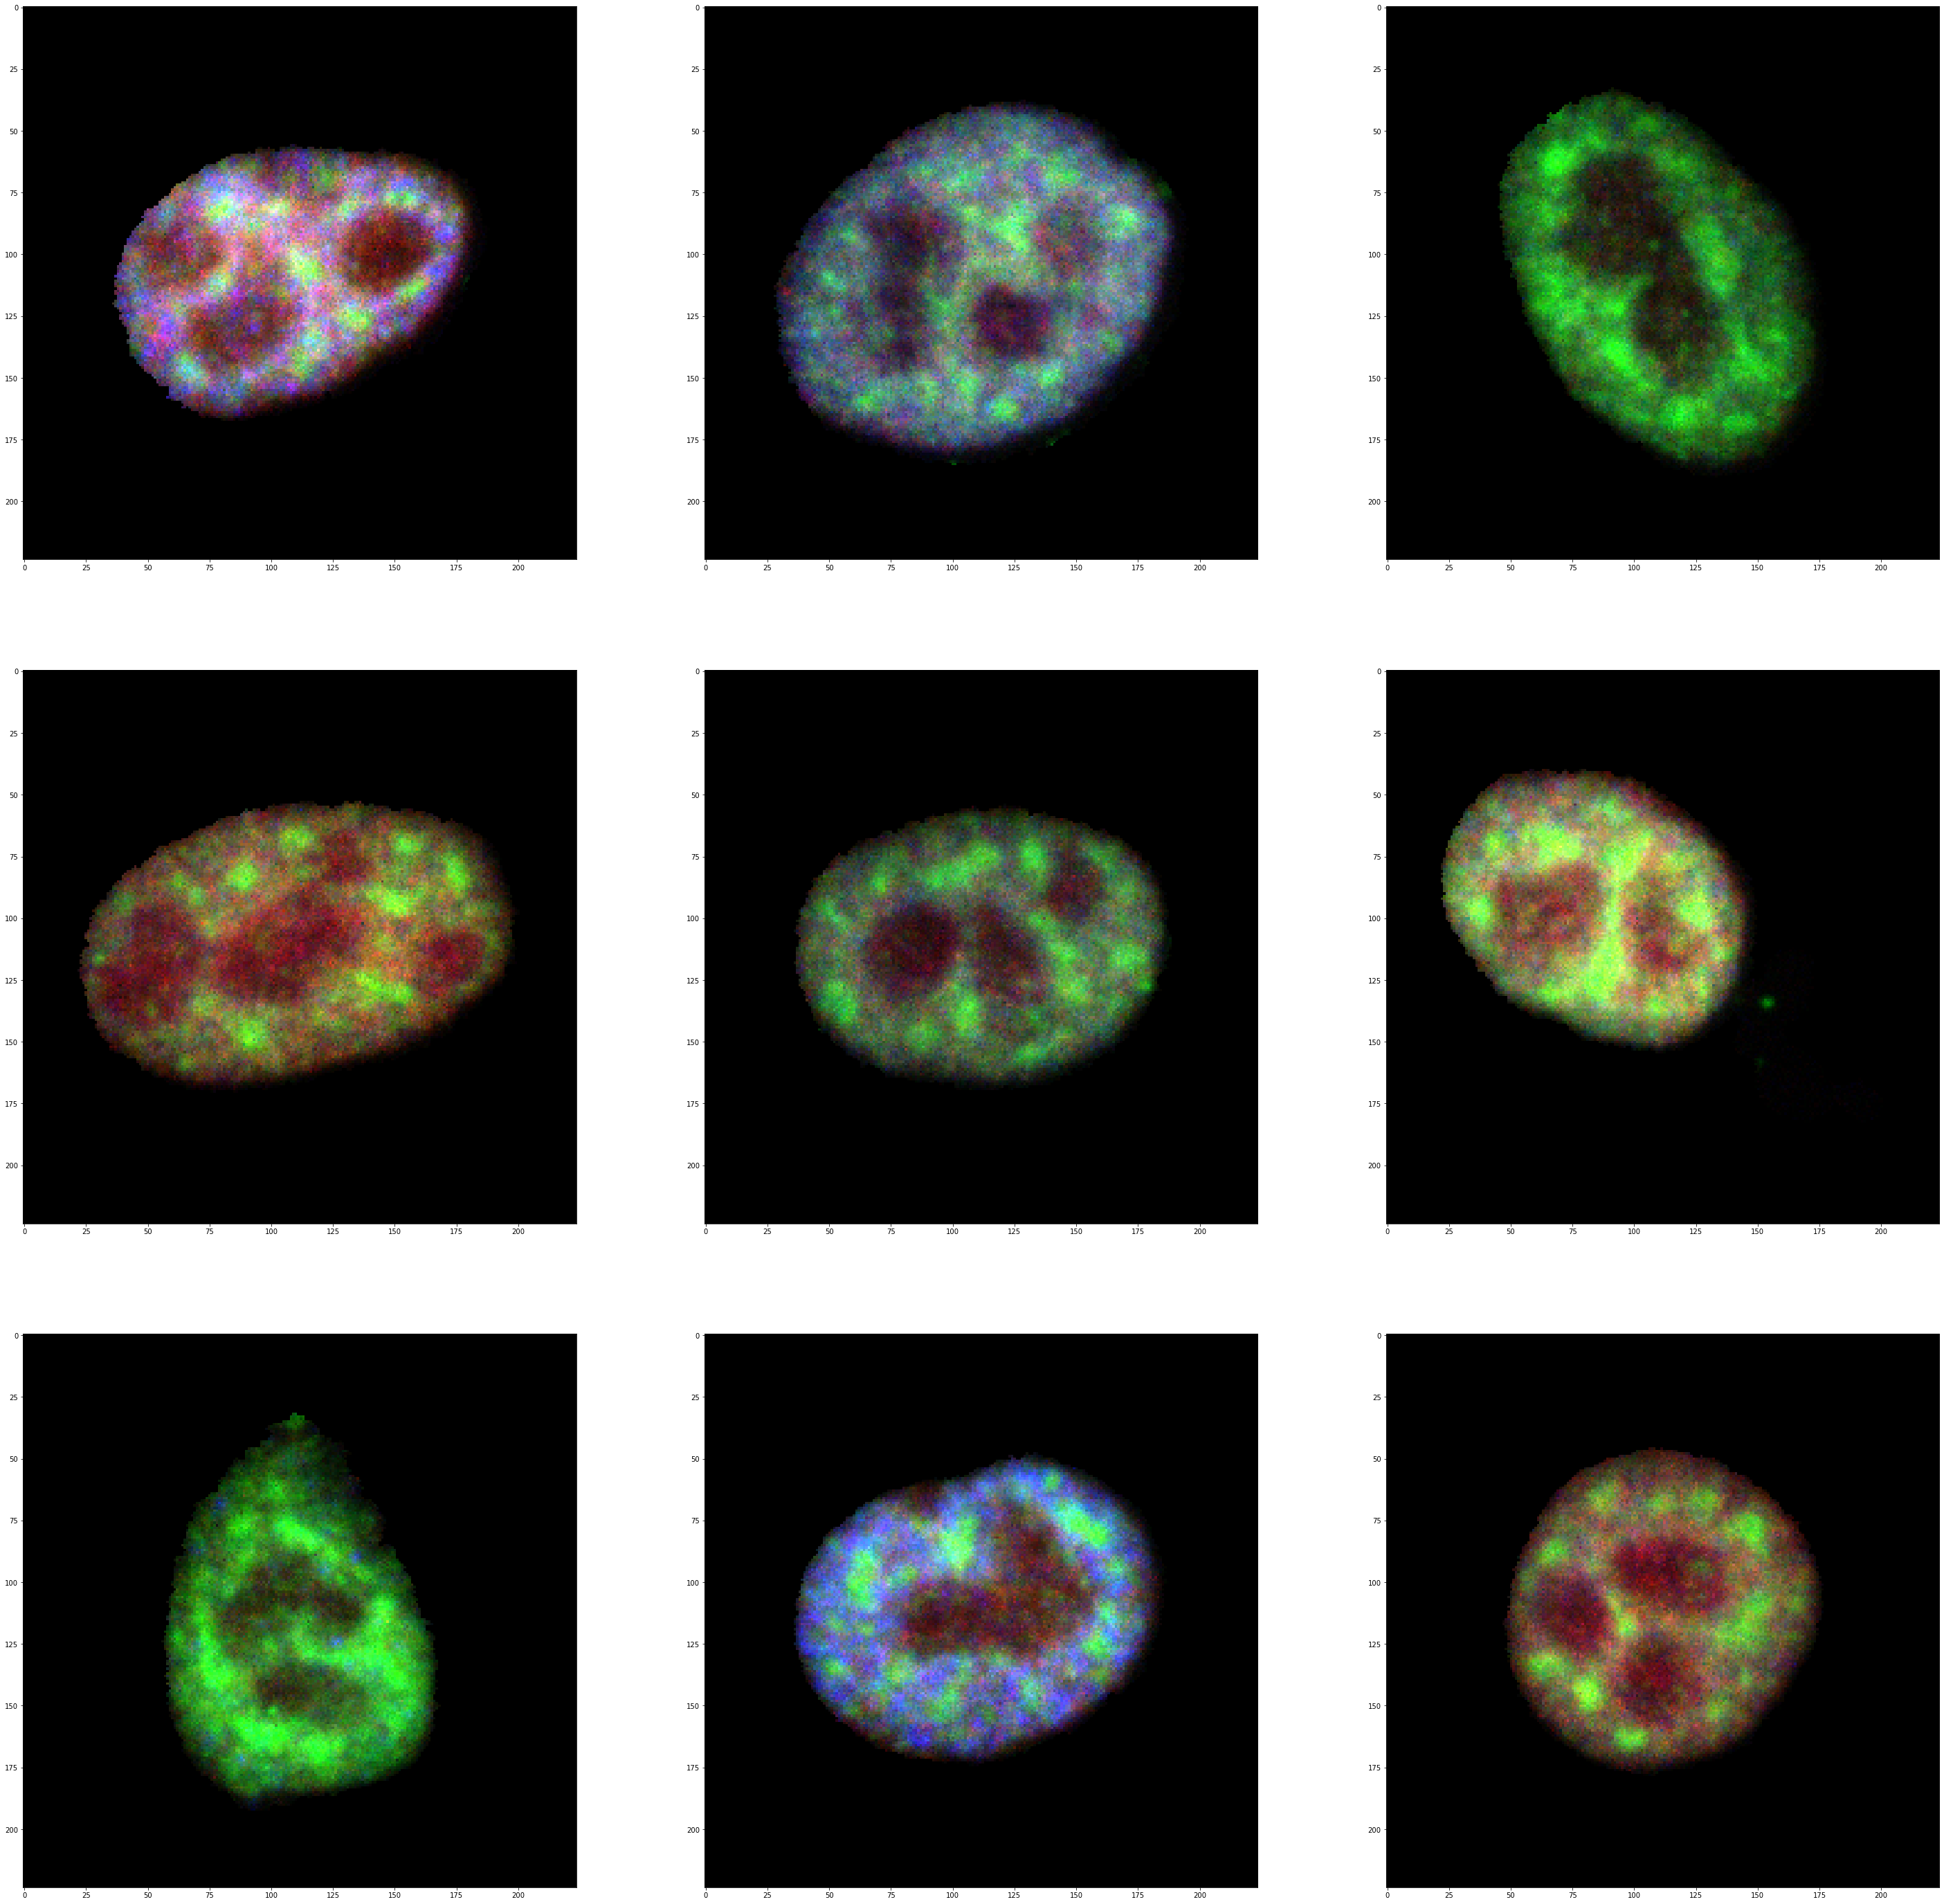

In [5]:
# Take a look into some of the images
plt.figure(figsize=(50,50))
for i, (img, _) in enumerate(train_data.take(9), 1):
    plt.subplot(3, 3, i)
    plt.imshow(img.numpy()[:,:,10:13],
               cmap=plt.cm.PiYG,
               vmin=0, vmax=1)
plt.show()

Model:

In [5]:
img_shape = metadata.features['image'].shape

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), 
                           padding='same',
                           activation=tf.nn.relu, 
                           input_shape=img_shape),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    
    tf.keras.layers.Conv2D(128, (3,3),
                           padding='same', 
                           activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
    
])

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.Huber(delta=1.0),
              #loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse', 'mean_absolute_error']
              #metrics=['mse']
             )

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      21376     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               102760704 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

In [8]:
# The first time you use the dataset the images will be loaded form disk
# Caching will keep them in memory, making training faster
#train_data = train_data.cache()
#val_data = val_data.cache()

# Prepare data
BATCH_SIZE = 32
n_train = metadata.splits['train'].num_examples
#.cache will keep in memory (ram) every image that was used, it will us ram as much as it can but without overflowing
train_data = train_data.cache().repeat().shuffle(buffer_size=128, reshuffle_each_iteration=True).batch(BATCH_SIZE)
val_data = val_data.cache().batch(BATCH_SIZE)
#train_data = train_data.repeat().shuffle(buffer_size=128, reshuffle_each_iteration=True).batch(BATCH_SIZE)
#val_data = val_data.batch(BATCH_SIZE)

In [9]:
# Fit model
history = model.fit(train_data, 
          validation_data=val_data,
          epochs=30, 
          steps_per_epoch=math.ceil(n_train/BATCH_SIZE))

Epoch 1/30
31/31 [==============================] - 96s 3s/step - loss: 71.0336 - mse: 11587.8252 - mean_absolute_error: 71.5320 - val_loss: 44.1606 - val_mse: 3498.9526 - val_mean_absolute_error: 44.6587
Epoch 2/30
31/31 [==============================] - 100s 3s/step - loss: 49.1622 - mse: 3994.6228 - mean_absolute_error: 49.6600 - val_loss: 56.7375 - val_mse: 4964.3110 - val_mean_absolute_error: 57.2367
Epoch 3/30
31/31 [==============================] - 99s 3s/step - loss: 40.8237 - mse: 2781.2808 - mean_absolute_error: 41.3220 - val_loss: 32.6524 - val_mse: 1815.4012 - val_mean_absolute_error: 33.1489
Epoch 4/30
31/31 [==============================] - 103s 3s/step - loss: 41.0675 - mse: 2824.6052 - mean_absolute_error: 41.5648 - val_loss: 48.6552 - val_mse: 3520.5042 - val_mean_absolute_error: 49.1524
Epoch 5/30
31/31 [==============================] - 103s 3s/step - loss: 38.7060 - mse: 2477.8831 - mean_absolute_error: 39.2029 - val_loss: 39.1710 - val_mse: 2439.0032 - val_mean_

In [28]:
# Save model
model_path = '/home/hhughes/Documents/Master_Thesis/Project/workspace/models'
model.save(os.path.join(model_path, 'model_3'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /home/hhughes/Documents/Master_Thesis/Project/workspace/models/model_3/assets


INFO:tensorflow:Assets written to: /home/hhughes/Documents/Master_Thesis/Project/workspace/models/model_3/assets


In [11]:
history.history.keys()

dict_keys(['loss', 'mse', 'mean_absolute_error', 'val_loss', 'val_mse', 'val_mean_absolute_error'])

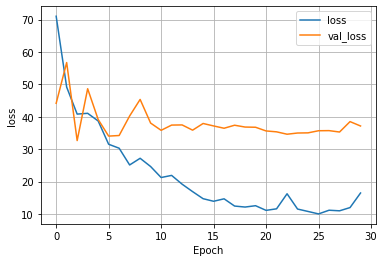

In [10]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.grid(True)
    #plt.ylim([0,0.01])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()

plot_loss(history)

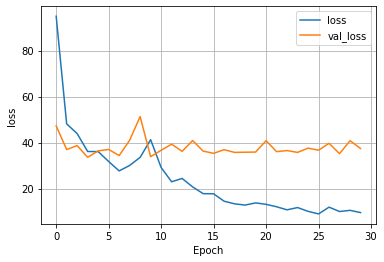

In [13]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.grid(True)
    #plt.ylim([0,0.01])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()

plot_loss(history)

In [108]:
# Evaluate test model
#test_predictions = model.predict(test_data).flatten()

m_shape = tuple([1]+list(img_shape))

y_test = []
y_test_hat = []
for (cell_img, y) in test_data:
    y_test.append(y.numpy()[0])
    y_test_hat.append(model.predict(tf.reshape(cell_img, m_shape))[0][0])

y_test = np.asarray(y_test)
y_test_hat = np.asarray(y_test_hat)

In [112]:
y_test_hat[0:10]

array([373.60794, 320.50208, 423.0435 , 402.04913, 400.8737 , 356.51556,
       390.03174, 492.57736, 394.696  , 465.7501 ], dtype=float32)

In [110]:
y_test[0:10]

array([359.00033569, 323.97988892, 391.45001221, 346.92224121,
       335.66775513, 359.09152222, 439.95574951, 397.33496094,
       370.46682739, 422.35687256])

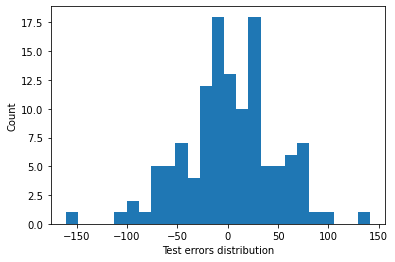

In [113]:
# Plot test data errors
plt.hist(y_test_hat - y_test, bins=25)
plt.xlabel('Test errors distribution')
_ = plt.ylabel('Count')

In [81]:
    sns.boxplot(y=param['method'],
                x='cell_cycle',
                hue='perturbation',
                hue_order=perturbation,
                order=cell_cycle,
                data=temp)
    
    sns.swarmplot(y=param['method'], 
                  data=temp_outlier, 
                  x='cell_cycle',
                  hue='perturbation',
                  hue_order=perturbation,
                  order=cell_cycle,
                  size=7, 
                  palette="Set3",
                  dodge=True,
#                  edgecolor='grey',
#                  linewidth=0.3
                  #color='red',
                 )

<AxesSubplot:xlabel='var', ylabel='values'>

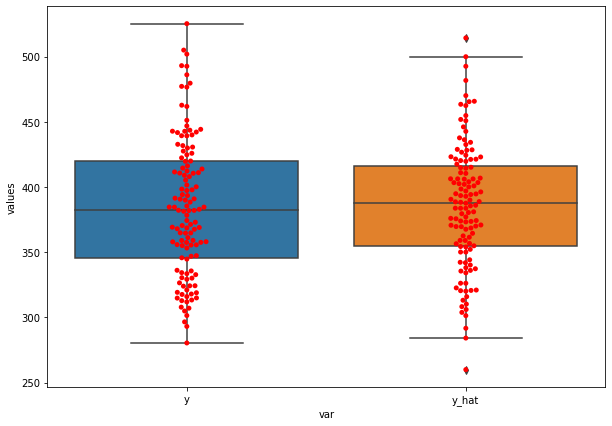

In [133]:
y_df = pd.DataFrame(y_test.reshape((-1,1)), columns=['values'])
y_df['var'] = 'y'
y_hat_df = pd.DataFrame(y_test_hat.reshape((-1,1)), columns=['values'])
y_hat_df['var'] = 'y_hat'
temp = pd.concat((y_df, y_hat_df), axis=0).reset_index()

plt.figure(figsize=(10,7))

sns.boxplot(y='values',
            x='var',
            data=temp)

sns.swarmplot(y='values',
              x='var',
              color='red',
              data=temp)